# Finding the Most Successful Strategy

Let's figure out which player archetype has the most succesful strategy in the long run if they play against each other.

In [ ]:
#pip install joblib matplotlib

In [ ]:
import logging
from functools import partial
import random

from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from maverick import Game, PlayerLike, PlayerState
from maverick.players import (
    TightAggressiveBot,
    LooseAggressiveBot,
    TightPassiveBot,
    LoosePassiveBot,
    ManiacBot,
    TiltedBot,
    BullyBot,
    GrinderBot,
    GTOBot,
    SharkBot,
    FishBot,
    ABCBot,
    HeroCallerBot,
    ScaredMoneyBot,
    WhaleBot,
)

# We don't want too much logging output here
logging.basicConfig(level=logging.WARNING)
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger("maverick").setLevel(logging.WARNING)

In [ ]:
player_types = [
    TightAggressiveBot,
    LooseAggressiveBot,
    TightPassiveBot,
    LoosePassiveBot,
    ManiacBot,
    TiltedBot,
    BullyBot,
    GrinderBot,
    GTOBot,
    SharkBot,
    FishBot,
    ABCBot,
    HeroCallerBot,
    ScaredMoneyBot,
    WhaleBot,
]

random.shuffle(player_types)
selected_player_types = player_types[:8]

In [3]:
# Function to play a game with specified parameters
def play_game(
    small_blind: int = 10,
    big_blind: int = 20,
    max_hands: int = 40,
    initial_stack: int = 1000,
) -> tuple[list[PlayerLike], Game]:
    game = Game(small_blind=small_blind, big_blind=big_blind, max_hands=max_hands)

    players: list[PlayerLike] = []
    for cls in selected_player_types:
        players.append(cls(name=cls.__name__, state=PlayerState(stack=initial_stack)))
        game.add_player(players[-1])

    game.start()

    return players, game

## Play a Single Game

Use the following cell to time the execution of a single play. Use the time it takes to play one game to set the number of games to play in the next section.

In [ ]:
# Test by playing a single game and printing the final stacks
players, game = play_game(small_blind=10, big_blind=20, max_hands=10, initial_stack=1000)
for player in players:
    print(f"{player.name} - Stack: {player.state.stack}")

LooseAggressiveBot - Stack: 1283
BullyBot - Stack: 220
GrinderBot - Stack: 1282
TightPassiveBot - Stack: 870
ManiacBot - Stack: 1281
TiltedBot - Stack: 1281
SharkBot - Stack: 1281
TightAggressiveBot - Stack: 502


## Play Many Games

Now play a bunch of games and visualize average payoffs. Here we define payoff as the final stack minus the initial stack. Since we have more player types than seats at the table, we are going to rotate the player types such that we randomly select 8 in each round.

In [5]:
payoffs = {a.__name__ : 0 for a in player_types}
num_games = {a.__name__ : 0 for a in player_types}

In [ ]:
n_games = 100  # number of games to simulate
n_jobs = 8     # number of parallel jobs

# Define game parameters
small_blind = 10
big_blind = 20
max_hands = 10         
initial_stack = 1000

# Create helper function with fixed parameters
play = partial(
    play_game, 
    small_blind=small_blind, 
    big_blind=big_blind, 
    max_hands=max_hands,
    initial_stack=initial_stack
)


def _simulate_one_game(seed: int):
    rng = random.Random(seed)

    # Pick 8 player types for this game
    chosen = rng.sample(player_types, k=8)

    # play_game reads `selected_player_types` globally
    global selected_player_types
    selected_player_types = chosen

    players, _ = play_game(
        small_blind=small_blind,
        big_blind=big_blind,
        max_hands=max_hands,
        initial_stack=initial_stack,
    )

    local_payoffs = {}
    local_counts = {}
    for p in players:
        name = p.__class__.__name__
        local_payoffs[name] = local_payoffs.get(name, 0) + (p.state.stack - initial_stack)
        local_counts[name] = local_counts.get(name, 0) + 1

    return local_payoffs, local_counts


# Generate random seeds for each game
seeds = [random.randrange(2**32) for _ in range(n_games)]

# Use joblib to parallelize game simulations
results = Parallel(n_jobs=n_jobs, prefer="processes")(
    delayed(_simulate_one_game)(s) for s in seeds
)

# Reduce results into the notebook-level dicts
for lp, lc in results:
    for name, v in lp.items():
        payoffs[name] += v
    for name, c in lc.items():
        num_games[name] += c

# Compute average payoffs    
average_payoffs = {name: payoffs[name]/num_games[name] for name in payoffs}

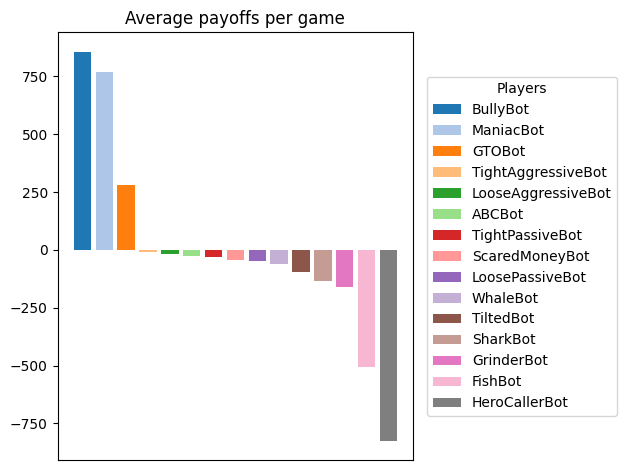

In [9]:
fig, ax = plt.subplots()

# Sort by payoff (descending)
sorted_items = sorted(average_payoffs.items(), key=lambda kv: kv[1], reverse=True)

names = [name for name, _ in sorted_items]
avg_payoffs = [payoff for _, payoff in sorted_items]

cmap = plt.get_cmap("tab20")
for i, (player_name, payoff) in enumerate(zip(names, avg_payoffs)):
    ax.bar(player_name, payoff, color=cmap(i % cmap.N), label=player_name)

ax.set_title("Average payoffs per game")
ax.legend(
    title="Players",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
)

# Remove x-axis labels (tick labels)
ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

plt.tight_layout()
plt.show()